In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to train and evaluate the model for a specific subgroup
def train_and_evaluate(X_train, X_test, y_train, y_test):
    best_params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}
    model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)
    return mae, rmse

In [3]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [4]:
%%bigquery train_df
SELECT * FROM `aa-ai-specialisation.black_friday.preprocessed_train_df`

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
%%bigquery test_df
SELECT * FROM `aa-ai-specialisation.black_friday.preprocessed_test_df`

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()
X = train_df_copy.drop(columns=['User_ID', 'Product_ID', 'Purchase'])
y = train_df_copy['Purchase'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
subgroups = {
    'Gender': [0, 1],
    'Age': train_df_copy['Age'].unique(),
    'Occupation': train_df_copy['Occupation'].unique(),
    'Marital_Status':[0,1],
    "City_A": [0, 1],
    "City_B": [0, 1],
    "City_C": [0, 1]
}


Evaluating for Gender = 0
Mean Absolute Error: 2175.9962696768853
Root Mean Squared Error: 2909.2087528090633

Evaluating for Gender = 1
Mean Absolute Error: 2001.1164978820013
Root Mean Squared Error: 2718.633831953952

Evaluating for Age = 2
Mean Absolute Error: 2188.1663372875873
Root Mean Squared Error: 2922.7410362858714

Evaluating for Age = 6
Mean Absolute Error: 1862.9682118197786
Root Mean Squared Error: 2597.5683673944745

Evaluating for Age = 1
Mean Absolute Error: 2252.6309854596952
Root Mean Squared Error: 3003.233136112643

Evaluating for Age = 5
Mean Absolute Error: 1945.1561827852656
Root Mean Squared Error: 2649.23503589098

Evaluating for Age = 0
Mean Absolute Error: 2236.399817135493
Root Mean Squared Error: 3020.564424079562

Evaluating for Age = 3
Mean Absolute Error: 2015.3744388586008
Root Mean Squared Error: 2735.2887291371776

Evaluating for Age = 4
Mean Absolute Error: 1974.0513880046863
Root Mean Squared Error: 2684.5499785179613

Evaluating for Occupation =

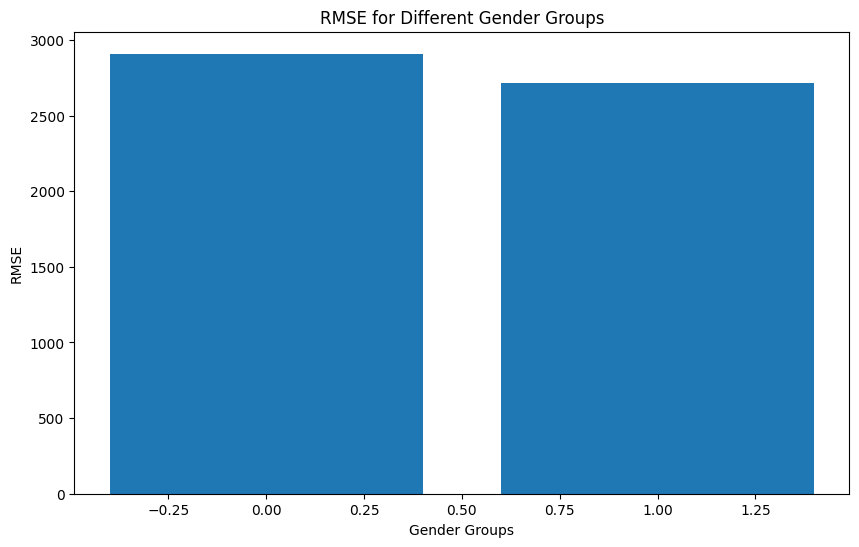

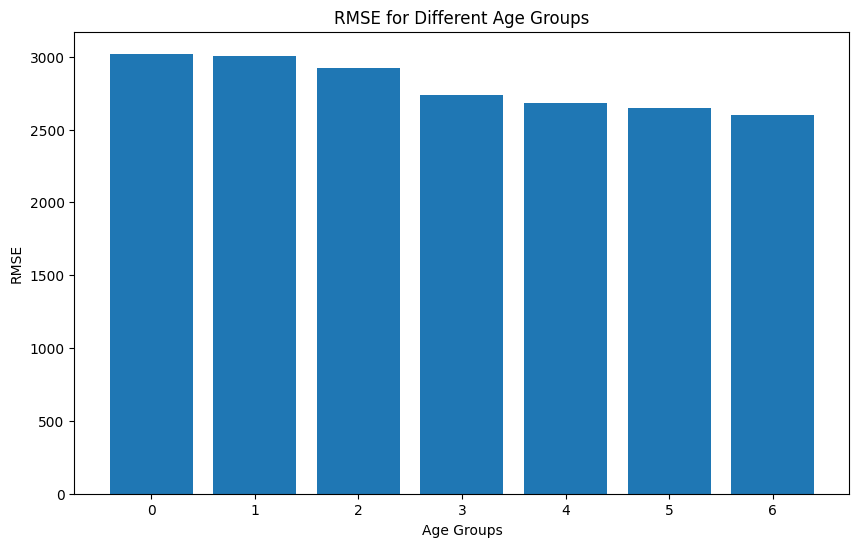

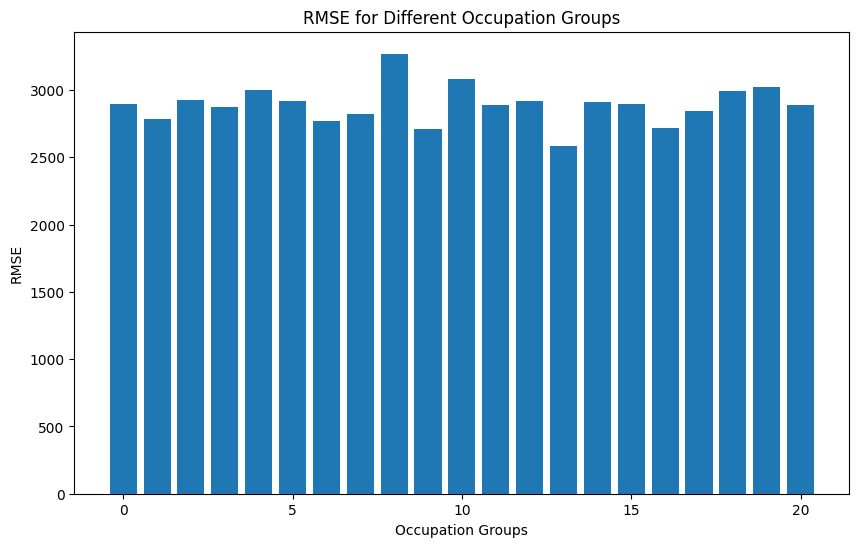

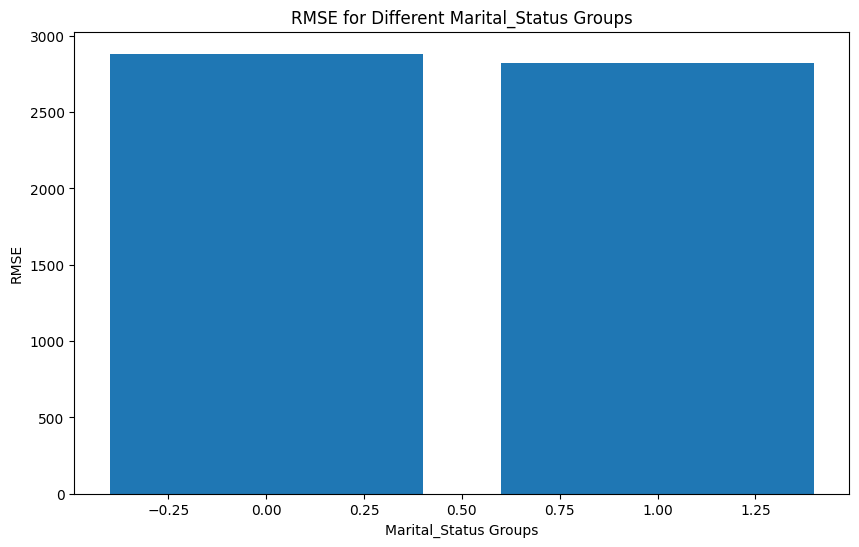

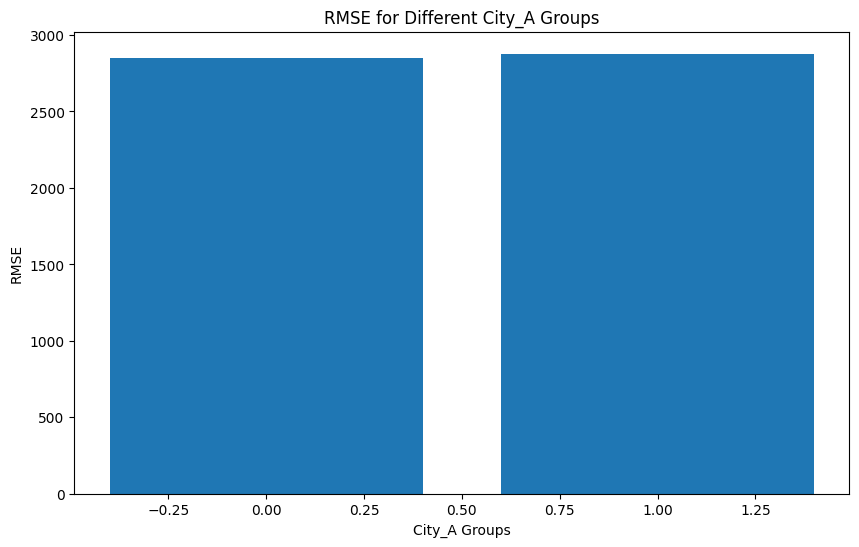

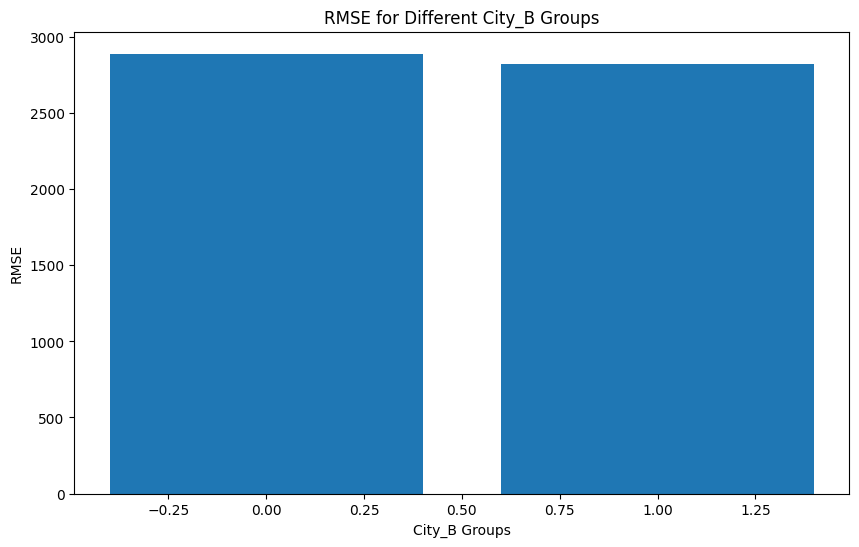

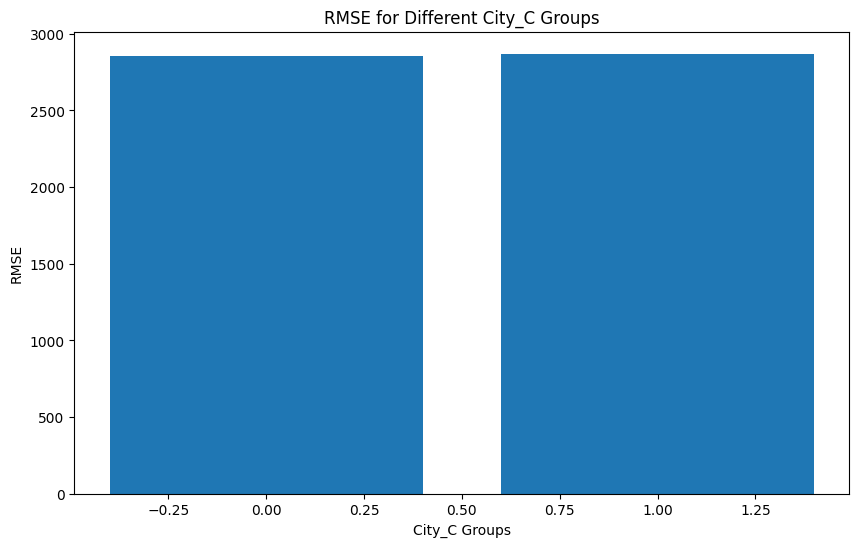

In [10]:
# Initialize a dictionary to store RMSE values for each subgroup
rmse_results = {}

# Analyzing performance across subgroups
for feature, groups in subgroups.items():
    rmse_results[feature] = {}
    for group in groups:
        print(f"\nEvaluating for {feature} = {group}")
        
        # Filter the train and test sets for the specific group
        X_train_subgroup = X_train[X_train[feature] == group].drop(feature, axis=1)
        X_test_subgroup = X_test[X_test[feature] == group].drop(feature, axis=1)
        y_train_subgroup = y_train[X_train[feature] == group]
        y_test_subgroup = y_test[X_test[feature] == group]

        # Train and evaluate the model
        mae, rmse = train_and_evaluate(X_train_subgroup, X_test_subgroup, y_train_subgroup, y_test_subgroup)
        print(f'Mean Absolute Error: {mae}')
        print(f'Root Mean Squared Error: {rmse}')

        # Store the RMSE in the results dictionary
        rmse_results[feature][group] = rmse

# Plotting the RMSE results
for feature, groups_rmse in rmse_results.items():
    plt.figure(figsize=(10, 6))
    plt.bar(groups_rmse.keys(), groups_rmse.values())
    plt.xlabel(f'{feature} Groups')
    plt.ylabel('RMSE')
    plt.title(f'RMSE for Different {feature} Groups')
    plt.show()
